# Modelling RAS-dependent RAF activation and RAF inhibition using rule-based modelling with energy and compartments

Here we develop a small model for RAF kinase activity, in which WT RAF are activated through dimerization and oncogenic RAF is active also as monomer (e.g. BRAF V600E/K alike). Dimerization is enhanced by increase of dimerization rate through recruitment of RAFs at the membrane by Ras-GTP, which we model using compartments. At the same time, we model RAF inhibition by allosteric small-molecules using energy-based reaction rates, which allows to define different types of allosteric effects of drugs vs RAF dimerization state. 

In [1]:
from pysb import Model, Monomer, Parameter, Expression, Rule, Observable, Initial, Annotation, EnergyPattern, Compartment, ANY
from pysb.bng import generate_equations
from pysb.simulator import ScipyOdeSimulator
from pysb.export import export
from pysb.core import as_complex_pattern, ComplexPattern
from sympy import exp, log
from tqdm.notebook import tqdm, trange
from util_simulation import equilibrate
import matplotlib.pyplot as plt
import numpy as np
import math

Create the model: 

In [2]:
Model();
model.name='RAS_RAF_RAFi_rules_compartments_energy';

Define a cytosolic (C) and membrane (M) compartments:

In [3]:
Parameter('M_vol', .001) 
Compartment('M', parent=None, dimension=2, size=M_vol)
Parameter('C_vol', 1)
Compartment('C', parent=M, dimension=3, size=C_vol);

Define species for RAS, RAF and RAF inhibitor: 

In [4]:
#Ras with a GDP or GTP state and a binding site for RAF
Monomer('Ras', ['raf', 'state'], {'state':['GTP']});   
#Raf with binding sites for Ras, Raf and RAFi
Monomer('Raf', ['ras', 'raf', 'i']); 
#Inhibitor with binding to RAF
Monomer('I', ['raf']); 

Initialize Ras at membrane, Raf and inhibitor in the cytosol:

In [5]:
Parameter('RasGTP_0', 0) # uM
Initial(Ras(state='GTP', raf=None)**M, RasGTP_0)
Parameter('Raf_0', 0.01) # uM
Initial(Raf(ras=None, raf=None, i=None)**C, Raf_0);
Parameter('I_0', 0) # uM
Initial(I(raf=None)**C, I_0);

Define non-energy reactions for Ras binding and recruting Raf to membrane: 

In [6]:
#define forward (kf) and reverse (kr) rate for Ras-GTP binding to Raf
Parameter('kr_GR', 10) #/s/uM
Parameter('kf_GR', 10.0) #/s

#define Ras-GTP binding to RAF
Rule('GR', Ras(state='GTP', raf=None)+ Raf(ras=None) | Ras(state='GTP', raf=1)%Raf(ras=1)  , kf_GR, kr_GR)

Rule('GR', Ras(raf=None, state='GTP') + Raf(ras=None) | Ras(raf=1, state='GTP') % Raf(ras=1), kf_GR, kr_GR)

Define the energy-based reactions for RAF dimerization and RAF inhibitor binding to RAF:

In [7]:
#define support functions that converts kinetic parameters kf, kr and phi into energy parameters Gf and Ea0
#as defined by Justin Hogg's PhD Thesis http://d-scholarship.pitt.edu/19621/

def ks_to_Gf(kf, kr):
    return log(kr/kf)

def ks_to_Ea0(kf, kr, phi):
    return -phi*log(kr/kf)-log(kf)

In [8]:
#define forward (kf), reverse (kr) and distribution rate (phi) for RAF dimerization
Parameter('kr_RR',10);  #/s
Parameter('kf_RR',1.0);  #/s/uM
Parameter('phi_RR',1.0); #unitless 

#define forward (kf), reverse (kr) and distribution rate (phi) for RAF binding to inhibitor
Parameter('kr_RI',0.1);  #/s
Parameter('kf_RI',1.0);  #/s/uM
Parameter('phi_RI',1.0); #unitless

#define thermodynamic factors f and g
Parameter('f',1.0);  #unitless 
Parameter('g',1.0);  #unitless

In [9]:
#convert kinetic parameters into energies for RAF dimerization
Expression('Gf_RR', ks_to_Gf(kf_RR, kr_RR) ); #unitless 
Expression('Ea0_RR', ks_to_Ea0(kf_RR, kr_RR, phi_RR)); #unitless 

#convert kinetic parameters into energies for drug binding to RAF
Expression('Gf_RI', ks_to_Gf(kf_RI, kr_RI)); #unitless 
Expression('Ea0_RI', ks_to_Ea0(kf_RI, kr_RI, phi_RI)); #unitless 

#convert thermodynamic factors into energies
Expression('Gf_f',log(f)); #unitless 
Expression('Gf_g',log(g)); #unitless 

In [10]:
# define energy in bond between R and R
EnergyPattern('ep_RR',Raf(raf=1)%Raf(raf=1),Gf_RR);

# define energy in bond between R and I
EnergyPattern('ep_RI',Raf(i=1)%I(raf=1),Gf_RI);

# define additional energy in bond betwee RAF dimer and a single drug molecule
Expression('Gf_RRI', Gf_f);
EnergyPattern('ep_RRI', Raf(raf=1,i=None)%Raf(raf=1,i=2)%I(raf=2), Gf_RRI);

# define additional energy in bond betwee RAF dimer and two drug molecules
Expression('Gf_IRRI', Gf_f + Gf_g);
EnergyPattern('ep_IRRI',I(raf=2)%Raf(raf=1,i=2)%Raf(raf=1,i=3)%I(raf=3), Gf_IRRI);

In [11]:
#define RAF dimerization reaction
Rule('RR', Raf(raf=None)+Raf(raf=None) | Raf(raf=1)%Raf(raf=1) , phi_RR, Ea0_RR, energy=True);

#define drug binding to RAF reaction
Rule('RI', Raf(i=None)+I(raf=None) | Raf(i=1)%I(raf=1) , phi_RI, Ea0_RI, energy=True);

Define observables and expressions to calculate RAF active as a dimer or as monomer:

In [12]:
# define observable for total RAF and total drug
Observable('Rtot_obs', Raf());
Observable('Itot_obs', I());

#define an observable that counts the amount of active RAF when RAF represents a BRAF V600E/K mutant
#that is active independently of dimerization stauts (i.e. both as a monomer or as a dimer) as long as it is not drug bound
Observable('R_BRAFmut_active_obs', Raf(i=None));

#define an observable that counts the amount of active RAF when RAF here represents a wild type version of BRAF or CRAF
#that is active only when dimerized and not drug bound
Observable('R_RAFwt_active_obs', Raf(raf=1,i=None)%Raf(raf=1));

# define observable for drug unbound RAF monomer
Observable('R_obs', Raf(i=None,raf=None), match='species');

# define observable for RAF dimer unbound by drug
Observable('RR_obs', Raf(raf=1,i=None)%Raf(raf=1,i=None), match='species');

# define observable for RAF dimer bound by single drug
Observable('RRI_obs', Raf(raf=1,i=None)%Raf(raf=1,i=2)%I(raf=2), match='species');

# define observable for RAF dimer bound by double drug
Observable('IRRI_obs', I(raf=2)%Raf(raf=1,i=2)%Raf(raf=1,i=3)%I(raf=3), match='species');

Generate the kinetic model and plot properties of the ODE system:

In [13]:
from util_display import display_model_info

# generate the model equations
generate_equations(model)

#display model informations
display_model_info(model)

#save the generated model in PySB and BNG format (SBML not supported for certain compartment models)
generated_model_code = export(model, 'pysb_flat')
with open(model.name+'.py', 'wt') as f:
    f.write(generated_model_code);
generated_model_code = export(model, 'bngl')
with open(model.name+'.bngl', 'wt') as f:
    f.write(generated_model_code); 

Model information
Species: 16
Parameters: 18
Expressions: 8
Observables: 8
Total Rules: 3
Energy Rules: 2
Non-energy Rules: 1
Energy Patterns: 4
Reactions: 60


Inspect the species and reactions generated from rules and compartments:

In [14]:
from util_display import format_species_reactions, display_table
import pandas as pd
# Prevent pandas from truncating long LaTeX expressions when rendering.
pd.options.display.max_colwidth=None

#obtain dataframe with math latex expression visualization for species and reactions
(speciesdisp, reactionsdisp)=format_species_reactions(model);
#display species with the right style
display_table(speciesdisp, caption='SPECIES');

#display reactions in the same order as Reaction List S3 in original publication 
display_table(reactionsdisp, caption='REACTIONS');

ID,Pattern
\[s_{0}\],"Ras(raf=None, state='GTP') ** M"
\[s_{1}\],"Raf(ras=None, raf=None, i=None) ** C"
\[s_{2}\],I(raf=None) ** C
\[s_{3}\],"Raf(ras=1, raf=None, i=None) ** C % Ras(raf=1, state='GTP') ** M"
\[s_{4}\],"Raf(ras=None, raf=1, i=None) ** C % Raf(ras=None, raf=1, i=None) ** C"
\[s_{5}\],"I(raf=1) ** C % Raf(ras=None, raf=None, i=1) ** C"
\[s_{6}\],"Raf(ras=2, raf=1, i=None) ** C % Raf(ras=None, raf=1, i=None) ** C % Ras(raf=2, state='GTP') ** M"
\[s_{7}\],"I(raf=1) ** C % Raf(ras=2, raf=None, i=1) ** C % Ras(raf=2, state='GTP') ** M"
\[s_{8}\],"I(raf=1) ** C % Raf(ras=None, raf=2, i=1) ** C % Raf(ras=None, raf=2, i=None) ** C"
\[s_{9}\],"Raf(ras=2, raf=1, i=None) ** C % Raf(ras=3, raf=1, i=None) ** C % Ras(raf=2, state='GTP') ** M % Ras(raf=3, state='GTP') ** M"


ID,Base rule,Reaction,Forward rate ($k$ ),Backward rate ($kr$ ),Dissociation constant ($K_d$ )
\[R_{0}\],GR,$s_{0}$ + $s_{1}$ ⇄ $s_{3}$,\[1.0 \cdot k_{GR}\],\[kr_{GR}\],\[\frac{1.0 \cdot kr_{GR}}{k_{GR}}\]
\[R_{1}\],RR,$s_{1}$ + $s_{1}$ ⇄ $s_{4}$,\[0.5 \cdot k_{RR}\],\[kr_{RR}\],\[\frac{2.0 \cdot kr_{RR}}{k_{RR}}\]
\[R_{2}\],RI,$s_{1}$ + $s_{2}$ ⇄ $s_{5}$,\[1.0 \cdot k_{RI}\],\[kr_{RI}\],\[\frac{1.0 \cdot kr_{RI}}{k_{RI}}\]
\[R_{3}\],GR,$s_{0}$ + $s_{4}$ ⇄ $s_{6}$,\[2.0 \cdot k_{GR}\],\[kr_{GR}\],\[\frac{0.5 \cdot kr_{GR}}{k_{GR}}\]
\[R_{4}\],GR,$s_{0}$ + $s_{5}$ ⇄ $s_{7}$,\[1.0 \cdot k_{GR}\],\[kr_{GR}\],\[\frac{1.0 \cdot kr_{GR}}{k_{GR}}\]
\[R_{5}\],RR,$s_{1}$ + $s_{3}$ ⇄ $s_{6}$,\[1.0 \cdot k_{RR}\],\[kr_{RR}\],\[\frac{1.0 \cdot kr_{RR}}{k_{RR}}\]
\[R_{6}\],RR,$s_{1}$ + $s_{5}$ ⇄ $s_{8}$,\[1.0 \cdot f^{- \phi_{RR}} \cdot k_{RR}\],\[f^{1 - \phi_{RR}} \cdot kr_{RR}\],\[\frac{1.0 \cdot f \cdot kr_{RR}}{k_{RR}}\]
\[R_{7}\],RR,$s_{3}$ + $s_{3}$ ⇄ $s_{9}$,\[500.0 \cdot k_{RR}\],\[kr_{RR}\],\[\frac{0.002 \cdot kr_{RR}}{k_{RR}}\]
\[R_{8}\],RR,$s_{3}$ + $s_{5}$ ⇄ $s_{10}$,\[1.0 \cdot f^{- \phi_{RR}} \cdot k_{RR}\],\[f^{1 - \phi_{RR}} \cdot kr_{RR}\],\[\frac{1.0 \cdot f \cdot kr_{RR}}{k_{RR}}\]
\[R_{9}\],RR,$s_{5}$ + $s_{5}$ ⇄ $s_{11}$,\[0.5 \cdot k_{RR} \cdot \left(\frac{1}{f \cdot g}\right)^{\phi_{RR}}\],\[kr_{RR} \cdot \left(f \cdot g\right)^{1 - \phi_{RR}}\],\[\frac{2.0 \cdot f \cdot g \cdot kr_{RR}}{k_{RR}}\]


Run simulations to study RAF inhibition:

In [15]:
#set up the ODE simulator for the model
sim = ScipyOdeSimulator(model);

In [16]:
#set the dilution range for the RAF inhibitor
RAFi_dil=np.logspace(-4, 1, 20, base=10.0); #uM
#set the values of f and g to model RAF inhibitors with different complex drug-protein interactions
#1st generation: f= 0.001, g=1000; panRAF: f= 0.001, g=1; dimer selective f=1, g=0.001
ff=[1, 0.001, 0.001];
gg=[1, 1000,  1];
fgtitle=['no_cooperativity', '1st_gen', 'pan_RAF'];
#set values for RasGTP
Ras_GTP_sim_0=[0.01, 0.05, 0.1, 0.25, 0.5, 1] #np.logspace(-1, 1, 7) # uM

Perform multiple simulations of the systems at each defined combination of thermodynamic parameters (f,g), RAF inhibitor concentration (RAFi) amd Ras-GTP abundance (Ras_GTP_sim_0): 

Simulation progress:   0%|          | 0/360 [00:00<?, ?it/s]

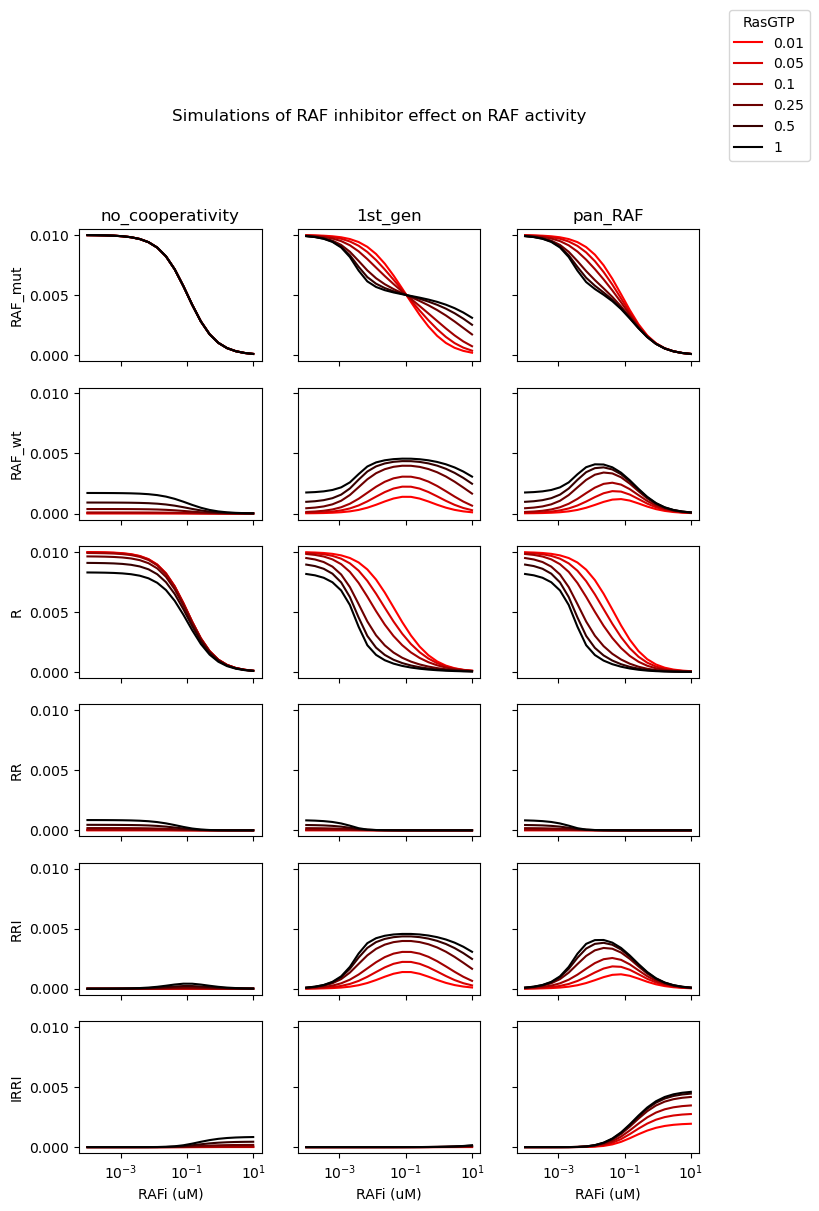

In [17]:
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

#create a bar to keep track of simulation progress
p_bar_sim = tqdm(desc='Simulation progress', total=len(ff)*len(Ras_GTP_sim_0)*len(RAFi_dil))

#define observables to plot
plt_obs=['R_BRAFmut_active_obs', 'R_RAFwt_active_obs', 'R_obs', 'RR_obs', 'RRI_obs', 'IRRI_obs'];
plot_obs_names=['RAF_mut', 'RAF_wt', 'R', 'RR', 'RRI', 'IRRI'];

#define figure 
fig, ax = plt.subplots(len(plt_obs),len(gg), figsize=(8, 12), sharey=True);
fig.suptitle("Simulations of RAF inhibitor effect on RAF activity");  

#define plot colors
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
#cmap=plt.get_cmap('winter');
col=cmap(np.linspace(0.0, 1.0, len(Ras_GTP_sim_0)))[::-1];

#simulate the different parameter combinations
ss_v = np.empty([len(RAFi_dil), len(plt_obs)]);
for i in range (len(ff)):
    for j in range(len(Ras_GTP_sim_0)):
        for k in range(len(RAFi_dil)):
            #run simulation with modified parameters
            param_values={'f': ff[i] ,'g': gg[i], 'RasGTP_0': Ras_GTP_sim_0[j], 'I_0': RAFi_dil[k]};
            #run this to assure model is run to steady_ state, 
            res=equilibrate(sim, param_values=param_values)
            #update progress
            p_bar_sim.update(1);
            #extract end of simulation for each osbervables from the dataframe of simulation results
            ss_v[k,:]=res.dataframe[plt_obs].iloc[-1];
                
        #plot the results for a given RR_KD and f,g combination
        for z in range(len(plt_obs)):
             #plot simualtion 
             h=ax[z,i].plot(RAFi_dil, ss_v[:,z], color = col[j,:]);   
             ax[z,i].set_xscale('log');
             #set axis names
             if (i==0):
                ax[z,i].set_ylabel(plot_obs_names[z]);
             if (z==0):
                ax[z,i].title.set_text(fgtitle[i]);
             if (z==(len(plt_obs)-1)):
                ax[z,i].set_xlabel('RAFi (uM)');
             else:
                ax[z,i].set_xticklabels([]);
                
#add legend
fig.legend(ax, labels= list(map(str, Ras_GTP_sim_0)) , 
           bbox_to_anchor=(1.04,1), loc="center right", borderaxespad=0.1,
           title="RasGTP");
#save figures in pdf format
fig.savefig('./figures/RAS_RAF_RAFi_dose_response.pdf')

### Model simulation of temporal dynamics during drug treatment

The previous simulations analyzed the drug-dose response of RAF to RAF inhibitors applied till steady-state drug treatment at fixed conditions (e.g. fixed level of RAF dimerization). However, drugs operate on proteins that experience dynamic perturbations, as for example from the activation of an upstream signal. In this second example, we simulate the behaviour of RAF inhibitors having different energetic properties during temporal changes in RAF dimerization through changes in the RAF dimerization rate. 

First, we generate the dynamic profile for the addtion of a RAF inhibitor and for a subsequent series of square pulses of increased RAF dimerization: 

In [63]:
#define the train of square pulses that define temporal dynamic control over RAF dimerization (Kf_RR)
ncycle=4;
ton=30;
toff=50;
toset=10;
Kf_RR_min=10**-2;
Kf_RR_max=10**2.5;

#set the concentration and time of addition of the RAFi inhibitor
RAFi_conc_init=0.0;
RAFi_conc_add=10.0;
RAFi_time_add=20;

#generate list of events that dynamically change RAFi 
t_events=[0.0, RAFi_time_add];
events=['I_0', 'I_0'];
events_value=[RAFi_conc_init, RAFi_conc_add];

#generate list of events that dynamically change Kf_RR
for i in range(ncycle):
    t_events= t_events + [t_events[-1] + toff + toset] + [t_events[-1] + ton + toff + toset] ;
    events= events + ['kf_RR'] + ['kf_RR'];
    events_value= events_value + [Kf_RR_max] + [Kf_RR_min];
    toset=0;
    
#generate dynamic signals for RAFi and Kf_RR
t_Kf_RR_dyn=[0.0];
Kf_RR_dyn=[Kf_RR_min];
t_RAFi=[0.0];
RAFi_dyn=[RAFi_conc_init];
for i in range(len(events)):
    if (events[i]=='kf_RR'):
        t_Kf_RR_dyn= t_Kf_RR_dyn + [t_events[i]] + [t_events[i]];
        Kf_RR_dyn= Kf_RR_dyn + [Kf_RR_dyn[-1]] + [events_value[i]];
    elif (events[i]=='I_0'):
        t_RAFi= t_RAFi + [t_events[i]] + [t_events[i]];
        RAFi_dyn= RAFi_dyn + [RAFi_dyn[-1]] + [events_value[i]];
t_RAFi= t_RAFi + [t_Kf_RR_dyn[-1]];
RAFi_dyn = RAFi_dyn + [RAFi_dyn[-1]];

Next, we define the energetic properties of two 1st generation RAF inhibitors which have the same kinetic rates but in which the cooperativity with RAF dimerization affects either the forward (RR_phi=1.0) or backward rate (RR_phi=0.0). Note that intermediate values for RR_phi (0<RR_phi<1) can be used to model various degree of forward/backward rate modulation. This will change how long lived are RAF dimers once induced by the dynamic pulses caused by RAS-GTP pulsing: 

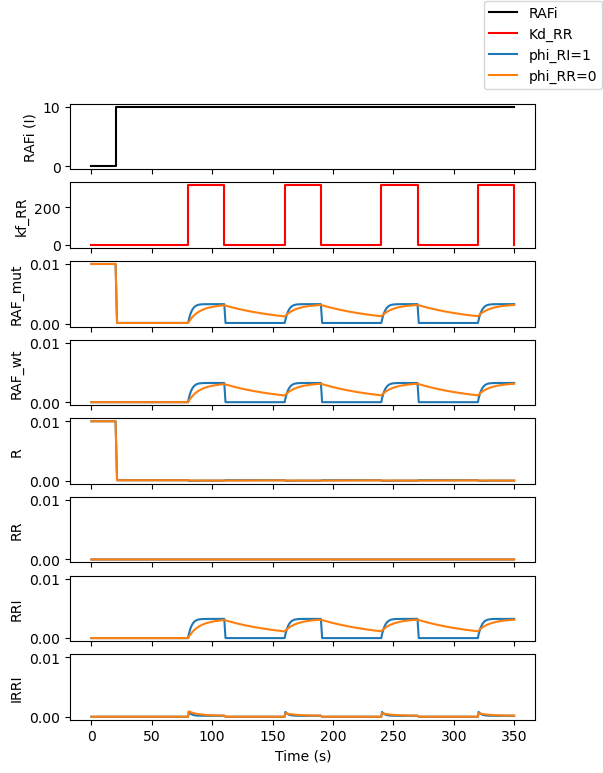

In [64]:
%matplotlib inline

#define energy parameters for the RAF inhibitors to be simulated
ff=[0.001, 0.001];
gg=[1000, 1000];
RI_phi=[1.0, 1.0];
RR_phi=[1.0, 0.0];
lgn_dyn=['RAFi','Kd_RR', 'phi_RI=1', 'phi_RR=0'];
        
#create figure for plotting 
fig, ax = plt.subplots(2+len(plt_obs), 1, figsize=(6, 8));
#plot dynamic RAFi concentration
ax[0].plot(t_RAFi, RAFi_dyn, color='k');
ax[0].set_ylabel('RAFi (I)');
ax[0].set_xticklabels([]);
#plot dynamic Kd_RR rate
ax[1].plot(t_Kf_RR_dyn, Kf_RR_dyn, color='r');
ax[1].set_ylabel('kf_RR');
ax[1].set_xticklabels([]);

#for each RAF inhibitor to be simulated
for i in range (len(ff)):
    #set up kinetic parameters and initial conditions (RAS-GTP set to zero since we are cotnrolling dimerization rate via kinetics for semplicity)
    param_values={'f': ff[i] ,'g': gg[i], 'phi_RI':RI_phi[i], 'phi_RR':RR_phi[i], 'kf_RR': Kf_RR_dyn[0], 'I_0': RAFi_dyn[0], 'RasGTP_0': 0};
    #run it to steady state before running drug addition and Kd_RR pulse train
    res=equilibrate(sim, param_values=param_values);
    #run consecutive simulations updating conditions according to events 
    #(drug addition, changes in Kd_RR) pulse train to set KdRR values
    res_obs=res.dataframe[plt_obs].to_records(index=False)[-1];
    t=[0.0];
    
    for j in range(len(events)-1):
        #save the state of the previous simulation to restart at same point
        initials_pre = res.dataframe.iloc[-1, :len(model.species)].copy();
        #create the tspan for simulation from these event to the next
        tspan= np.linspace(t_events[j], t_events[j+1]);
        #update param values with the event value
        param_values[events[j]]=events_value[j];
        #if the drug changed, set it in the current species states
        if (events[j]=="I_0"):
            #get index of inhibitor specie
            i_I_0=model.get_species_index(as_complex_pattern(model.monomers.I(raf=None)**C));
            initials_pre[i_I_0]=events_value[j];        
        #run the simulation for the necessary time (until next event)
        res=sim.run(tspan=tspan, param_values=param_values, initials=np.array(initials_pre));
        #append the observables
        res_obs=np.append(res_obs[plt_obs],res.dataframe[plt_obs].to_records(index=False)); 
        #append simulation time
        t=np.append(t,tspan);
        
    #plot the results for a given setting of parameters
    for z in range(len(plt_obs)):
             #set same yaxes
             if (z>0):
                ax[z].get_shared_y_axes().join(ax[2], ax[z+2]);
             #plot simualtion 
             h=ax[z+2].plot(t, res_obs[plt_obs[z]]);   
             #set axis names
             ax[z+2].set_ylabel(plot_obs_names[z]);
             if (z==(len(plt_obs)-1)):
                ax[z+2].set_xlabel('Time (s)');
             else:
                ax[z+2].set_xticklabels([]);
#add legend
fig.legend(ax, labels=lgn_dyn , loc="upper right", borderaxespad=0.1);     
#save figure in pdf format
fig.savefig('./figures/RAS_RAF_RAFi_dynamics.pdf')

The simulation shows that distribution rates, which define how changes in cooperativity affect forward or backward rates, can greatly influce drug efficacy during dynamic perturations. In this case, two 1st generation RAF inhibitors with different distribution rates, but having the exact same forward and backward rates, behave very differently when a dynamic perturbation in RAF dimerization is applied the system. By changing the distribution rate from RR_phi=0 to RR_phi=1, the cooperativity imposed between drug binding and RAF dimerization shifts from controlling the rate of RAF dissasembly to control the rate of RAF assembly. In the case of RR_phi=0, the drug binding to RAF dimers slows their disassembly after the dimerization signal disappears, those creating a continuous RAF signal that can cause resistance (RAF_mut, second row) or toxicity (RAF_wt). Instead, in the case of RR_ph=1, the drug binding to RAF dimers increases the speed of their assembly when the dimerization signal appears. This causes a slightly faster induction of RAF dimers, but removes the continous activation seen in the previous case. The beahviour of drugs with complex interactions with targeted proteins is thus influenced not just by their forward and backward rates, but also by the way in which cooperativity affects assembly/dissasembly rates of multiprotein-drug complexes.